# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0-preview.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Using TensorFlow like Numpy

## Tensors and operations

You can create a tensor with `tf.constant()`.

### Tensors

In [2]:
tf.constant([[1., 2., 3.], [4., 5., 6.]]) # matrix: 2x3

<tf.Tensor: id=0, shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [3]:
tf.constant(42) # scalar

<tf.Tensor: id=1, shape=(), dtype=int32, numpy=42>

Just like an `ndarray`, a `tf.Tensor` has a shape and a data type (dtype):

In [4]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t

<tf.Tensor: id=2, shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [5]:
t.shape

TensorShape([2, 3])

In [6]:
t.dtype

tf.float32

### Indexing
Indexing works much like in Numpy:

In [7]:
t[:, 1:]

<tf.Tensor: id=6, shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [8]:
t[..., 1, tf.newaxis]

<tf.Tensor: id=10, shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

In [9]:
t[..., 1]

<tf.Tensor: id=14, shape=(2,), dtype=float32, numpy=array([2., 5.], dtype=float32)>

### Ops
Most importantly, all sorts of tensor operations are available:

In [10]:
t + 10

<tf.Tensor: id=16, shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [11]:
tf.square(t)

<tf.Tensor: id=17, shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [12]:
t @ tf.transpose(t) # equivalant to tf.matmul( )

<tf.Tensor: id=20, shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

You will find all the basic math operations you need and most operations that you can find in Numpy ( e.g., `tf.reshape()`, `tf.exp()`, `tf.squeeze()`, `tf.tile()`). Some funcitons have a different name than in Numpy; for instance, `tf.reduce_mean()`, `tf.reduce_sum()`, `tf.reduce_max()`, and `tf.math.log()` are the equivalent of `np.mean()`, `np.sum()`, `np.max()`, and `np.log()`.

> Many functions and classes have aliases. For example, `tf.add()` and `tf.math.add()` are the same function. This allows TensorFlow to have concise names for the most common operations while preserving well-organized packaged.

### Using `keras.backend`

The Keras API has its own low-level API, located in `keras.backend`. It includes functions like `square()`, `exp()`, and `sqrt()`. In `tf.keras`, these functions generally just call the corresponding TensorFlow operations. **If you want to write code that will be portable to other Keras implementations**, you should use these keras functions, insteand of `tf.function()`s. However, they only cover a subset of all functions available in TensorFlow. FYI, `keras.backend` is commonly used as `K` for short:

In [13]:
from tensorflow import keras
K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: id=25, shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

### From/To NumPy
Tensors play nice with Numpy: you can create a tensor from a NumPy array, and vice versa. You can even apply TensorFlow operations to NumPy arrays and NumPy operations to tensors:

In [14]:
a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: id=26, shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [15]:
t.numpy() # or np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [16]:
np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [17]:
tf.square(a)

<tf.Tensor: id=28, shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [18]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

> Notice that NumPy uses 64-bit precision by default, while TensorFlow uses 32-bit. This is because 32-bit precision is generally more than enough for neural networks, plus it runs faster and uses less RAM. So, when you create a tensor from a numpy array, **make sure to set `dtype=tf.float32`.**

### Conflicting Types
Type conversions can significantly hurt performance, and they can easily go unnoticed when they are done automatically. To avoid this, **TensorFlow does not perform any type conversions automatically: it just raises an exception if you try to execute an operation on tensors with incompatible types**. For example, you cannot add a float tensor and an integer tensor, and you cannot even add a 32-bit float and a 64-bit float:

In [19]:
try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2] name: add/


In [20]:
try:
    tf.constant(2.0) + tf.constant(40., dtype=tf.float64)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2] name: add/


In [21]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: id=36, shape=(), dtype=float32, numpy=42.0>

### Variables

The `tf.Tensor` values we've seen so far are immutable: you cannot modify them. This means that we cannot use regular tensors to implement weights in a neural network, since they need to be tweaked by backpropagation. Plus, other parameters may also need to change over time(e.g., a moment optimizer keeps trak of past gradients). What we need is a `tf.Variable`:

In [22]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

A `tf.Variable` acts much like a `tf.Tensor`: you can perform the same operations with it, it plays nicely with NumPy as well, and it is just as picky with types. But it can also be modified in place using the `assign()` method (or `assign_add()` or `assign_sub()`, which increment or decrement the variable by the given value). You can also modify individual cells (or slices), by using the cell's (or slice's) `assign()` method(direct assignment will not work) or by using the `scatter_update()` or `scatter_nd_update()` methods:

In [23]:
v.assign(2*v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [24]:
v.numpy()

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)

In [25]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [26]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [27]:
v.scatter_nd_update([[0,0], [1, 2]], updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

> In practice you will raely have to create variables manually, since Keras provides an `add_weight()` method that will take care of it for you, as we will see. Moreover, model parameters will generally be updated directly by the optimzers, so you will rarely need to update variables manually.

## Other Data Structures

### Strings

In [28]:
tf.constant(b"hello world")

<tf.Tensor: id=68, shape=(), dtype=string, numpy=b'hello world'>

In [29]:
tf.constant("café")

<tf.Tensor: id=69, shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [30]:
u = tf.constant([ord(c) for c in "café"])
u

<tf.Tensor: id=70, shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

In [31]:
b = tf.strings.unicode_encode(u, "UTF-8")
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: id=81, shape=(), dtype=int32, numpy=4>

In [32]:
tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: id=85, shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

### String arrays

In [33]:
p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])

In [34]:
tf.strings.length(p, unit="UTF8_CHAR")

<tf.Tensor: id=87, shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2], dtype=int32)>

In [35]:
r = tf.strings.unicode_decode(p, "UTF8")
r

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857]]>

In [36]:
print(r)

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857]]>


### Ragged tensors
A ragged tensor is a special kind of tensor that represents a list of arrays of different sizes. More generally, it is a tensor with one or more *ragged dimensions*, meaning dimensions whose slices may have different lengths.

In [37]:
print(r[1])

tf.Tensor([ 67 111 102 102 101 101], shape=(6,), dtype=int32)


In [38]:
print(r[1:3])

<tf.RaggedTensor [[67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232]]>


In [39]:
r2 = tf.ragged.constant([[65, 66], [], [67]])
r2

<tf.RaggedTensor [[65, 66], [], [67]]>

In [40]:
print(tf.concat([r, r2], axis=0)) # along the axis 0

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857], [65, 66], [], [67]]>


In [41]:
r3 = tf.ragged.constant([[68, 69, 70], [71], [], [72, 73]])
print(tf.concat([r, r3], axis=1)) # along the axis 1

<tf.RaggedTensor [[67, 97, 102, 233, 68, 69, 70], [67, 111, 102, 102, 101, 101, 71], [99, 97, 102, 102, 232], [21654, 21857, 72, 73]]>


In [42]:
tf.strings.unicode_encode(r3, "UTF-8")

<tf.Tensor: id=237, shape=(4,), dtype=string, numpy=array([b'DEF', b'G', b'', b'HI'], dtype=object)>

If you call the `to_tensor()` method, it gets converted to a regular tensor, padding shorter tensors with *zeros* to get tensors of equal lengths (you can change the default value by setting the `default_value` argument):

In [43]:
r.to_tensor()

<tf.Tensor: id=302, shape=(4, 6), dtype=int32, numpy=
array([[   67,    97,   102,   233,     0,     0],
       [   67,   111,   102,   102,   101,   101],
       [   99,    97,   102,   102,   232,     0],
       [21654, 21857,     0,     0,     0,     0]], dtype=int32)>

### Sparse tensors
TensorFlow can also efficiently represent *sparse tensors* (i.e., tensors containing mostly zeros). Just create a `tf.SparseTensor`, specifying the indices and values of the nonzero elements and the tensor's shape. The indices must be listed in "reading order" (from left to right, and top to bottom). If you are unsure, just use `tf.sparse.reorder()`. You can convert a sparse tensor to a dense tensor using `tf.sparse.to_dense()`:

In [44]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]],
                    values=[1., 2., 3.],
                    dense_shape=[3, 4])

In [45]:
print(s)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [46]:
tf.sparse.to_dense(s)

<tf.Tensor: id=307, shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [47]:
s2 = s * 2.0

In [48]:
try:
    s3 = s + 1.
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [49]:
s4 = tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
tf.sparse.sparse_dense_matmul(s, s4)

<tf.Tensor: id=311, shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [50]:
s5 = tf.SparseTensor(indices=[[0, 2], [0, 1]],
                     values=[1., 2.],
                     dense_shape=[3, 4])
print(s5)

SparseTensor(indices=tf.Tensor(
[[0 2]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([1. 2.], shape=(2,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [51]:
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

indices[1] = [0,1] is out of order [Op:SparseToDense]


In [52]:
s6 = tf.sparse.reorder(s5) # reorder index-value pairs
tf.sparse.to_dense(s6)

<tf.Tensor: id=320, shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

### Sets
TensorFlow supports sets of integers or strings (but not floats). It represents them using regular tensors. For example, the set {1, 5, 9} is just represented as the tensor[[1, 5, 9]]. Note that the tensor must have at least two dimensions, and the sets must be in the last dimension.

In [53]:
set1 = tf.constant([[2, 3, 5, 7], [7, 9, 0, 0]])
set2 = tf.constant([[4, 5, 6], [9, 10, 0]])
tf.sets.union(set1, set2)

In [54]:
tf.sparse.to_dense(tf.sets.union(set1, set2))

<tf.Tensor: id=330, shape=(2, 6), dtype=int32, numpy=
array([[ 2,  3,  4,  5,  6,  7],
       [ 0,  7,  9, 10,  0,  0]], dtype=int32)>

In [55]:
tf.sparse.to_dense(tf.sets.difference(set1, set2))

<tf.Tensor: id=335, shape=(2, 3), dtype=int32, numpy=
array([[2, 3, 7],
       [7, 0, 0]], dtype=int32)>

In [56]:
tf.sparse.to_dense(tf.sets.intersection(set1, set2))

<tf.Tensor: id=340, shape=(2, 2), dtype=int32, numpy=
array([[5, 0],
       [0, 9]], dtype=int32)>

### Tensor Arrays

A `tf.TensorArray` represents a list of tensors. This can be handy in dynamic models containing loops, to accumulate results and later compute some statistics. You can read or write tensors at any location in any array:

In [57]:
array = tf.TensorArray(dtype=tf.float32, size=3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))

In [58]:
array.read(1)

<tf.Tensor: id=343, shape=(2,), dtype=float32, numpy=array([ 3., 10.], dtype=float32)>

> Notice that reading an item pops it from the array, replacing it with a tensor of the same shape, full of zeros

When creating a `TensorArray`, you must provide its **size**, except in graph mode. Alternatively, you can leave the size unset and instead set `dynamic_size=True`, but this will hinder performance, so if you know the `size` in advance, you should set it. You must also specify the `dtype`, and all elements must have the same shape as the first one written to the array.

You can stack all the items into a regular tensor by calling the `stack()` method:

In [59]:
array.stack()

<tf.Tensor: id=348, shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

In [60]:
mean, variance = tf.nn.moments(array.stack(), axes=0)
mean

<tf.Tensor: id=356, shape=(2,), dtype=float32, numpy=array([2., 3.], dtype=float32)>

In [61]:
variance

<tf.Tensor: id=357, shape=(2,), dtype=float32, numpy=array([4.6666665, 8.666667 ], dtype=float32)>

## Custom loss function

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [62]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [63]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

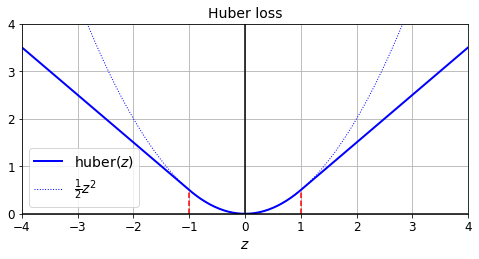

In [64]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [65]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [66]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [67]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 102us/sample - loss: 0.6068 - mae: 0.9614 - val_loss: 0.2129 - val_mae: 0.5062
Epoch 2/2
11610/11610 [==============================] - 0s 40us/sample - loss: 0.2094 - mae: 0.5034 - val_loss: 0.2088 - val_mae: 0.4930


Sweet! But what happens to this custom loss when you save the model?

## Saving/Loading Models with Custom Objects

Saving a model containing a custom loss function works fine, as Keras saves the name of the function. Whenver you load it, you will need to provide a dictionary that maps the function name to the actual function. More generally, when you load a model containing custom objects, you nneed to map the names to the objects:

In [68]:
model.save("my_model_with_a_custom_loss.h5")

In [69]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

In [70]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 68us/sample - loss: 0.2005 - mae: 0.4900 - val_loss: 0.1886 - val_mae: 0.4731
Epoch 2/2
11610/11610 [==============================] - 0s 41us/sample - loss: 0.1959 - mae: 0.4840 - val_loss: 0.1859 - val_mae: 0.4652


With the current implementation, any error between -1 and 1 is considered "small". But what if you want a different threshold? One solution is to create a function that creates a configures loss function:

In [71]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [72]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [73]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 91us/sample - loss: 0.2184 - mae: 0.4843 - val_loss: 0.2044 - val_mae: 0.4656
Epoch 2/2
11610/11610 [==============================] - 0s 41us/sample - loss: 0.2138 - mae: 0.4794 - val_loss: 0.2152 - val_mae: 0.4770


Unfortunately, when you save the model, the `threshold` will not be saved. This means that you will have to specify the `threshold` value when loading the model (note that the name to use is "`huber_fn`", which is the name of the function you gave Keras, not the name of the function that created it):

In [74]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

In [75]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)}) # not create_huber

In [76]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 66us/sample - loss: 0.2112 - mae: 0.4778 - val_loss: 0.2319 - val_mae: 0.4782
Epoch 2/2
11610/11610 [==============================] - 0s 41us/sample - loss: 0.2078 - mae: 0.4728 - val_loss: 0.2329 - val_mae: 0.4811


You can solve this by creating a subclass of the `keras.losses.Loss` class, and then implementing its `get_config()` method:

In [77]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [78]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [79]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [80]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 95us/sample - loss: 0.7851 - mae: 0.9445 - val_loss: 0.3375 - val_mae: 0.5680
Epoch 2/2
11610/11610 [==============================] - 0s 41us/sample - loss: 0.2581 - mae: 0.5268 - val_loss: 0.2546 - val_mae: 0.5106


In [81]:
model.save("my_model_with_a_custom_loss_class.h5")

In [82]:
# model = keras.models.load_model("my_model_with_a_custom_loss_class.h5", # TODO: check PR #25956
#                                custom_objects={"HuberLoss": HuberLoss})

In [83]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 43us/sample - loss: 0.2393 - mae: 0.5107 - val_loss: 0.2357 - val_mae: 0.4938
Epoch 2/2
11610/11610 [==============================] - 0s 41us/sample - loss: 0.2300 - mae: 0.5028 - val_loss: 0.2559 - val_mae: 0.5012


In [84]:
#model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",  # TODO: check PR #25956
#                                custom_objects={"HuberLoss": HuberLoss})

In [85]:
model.loss.threshold

2.0

## Other Custom Functions

In [86]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [87]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [88]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [89]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [90]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 86us/sample - loss: 1.7654 - mae: 0.8716 - val_loss: inf - val_mae: inf
Epoch 2/2
11610/11610 [==============================] - 0s 41us/sample - loss: 0.8443 - mae: 0.5355 - val_loss: inf - val_mae: inf


In [91]:
model.save("my_model_with_many_custom_parts.h5")

In [92]:
# TODO: 
"""
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer(0.01),
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })
"""

'\nmodel = keras.models.load_model(\n    "my_model_with_many_custom_parts.h5",\n    custom_objects={\n       "my_l1_regularizer": my_l1_regularizer(0.01),\n       "my_positive_weights": my_positive_weights,\n       "my_glorot_initializer": my_glorot_initializer,\n       "my_softplus": my_softplus,\n    })\n'

In [93]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

In [94]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [95]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [96]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 98us/sample - loss: 2.0967 - mae: 0.9215 - val_loss: inf - val_mae: inf
Epoch 2/2
11610/11610 [==============================] - 0s 41us/sample - loss: 0.9426 - mae: 0.5375 - val_loss: inf - val_mae: inf


In [97]:
model.save("my_model_with_many_custom_parts.h5")

In [98]:
# TODO: check https://github.com/tensorflow/tensorflow/issues/26061
"""
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })
"""

'\nmodel = keras.models.load_model(\n    "my_model_with_many_custom_parts.h5",\n    custom_objects={\n       "MyL1Regularizer": MyL1Regularizer,\n       "my_positive_weights": my_positive_weights,\n       "my_glorot_initializer": my_glorot_initializer,\n       "my_softplus": my_softplus,\n    })\n'

## Custom Metrics

In [99]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
    ])

In [100]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [101]:
model.fit(X_train_scaled, y_train, epochs=2)

Train on 11610 samples
Epoch 1/2
11610/11610 [==============================] - 1s 69us/sample - loss: 1.8225 - huber_fn: 0.8078
Epoch 2/2
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5463 - huber_fn: 0.2546


**Warning**: if you use the same function as the loss and a metric, you may be surprised to see different results. This is generally just due to floating point precision errors: even though the mathematical equations are equivalent, the operations are not run in the same order, which can lead to small differences. Moreover, when using sample weights, there's more than just precision errors:
* the loss since the start of the epoch is the mean of all batch losses seen so far. Each batch loss is the sum of the weighted instance losses divided by the _batch size_ (not the sum of weights, so the batch loss is _not_ the weighted mean of the losses).
* the metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is the weighted mean of all the instance losses. Not the same thing.

If you do the math, you will find that metric = loss * mean of sample weights (plus some floating point precision error).

In [102]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

In [103]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Train on 11610 samples
Epoch 1/2
11610/11610 [==============================] - 1s 80us/sample - loss: 0.1170 - huber_fn: 0.2361
Epoch 2/2
11610/11610 [==============================] - 0s 33us/sample - loss: 0.1121 - huber_fn: 0.2268


In [104]:
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

(0.11698175569888747, 0.11715538042284582)

### Streaming metrics

For each batch during training, Keras will compute this metric and keep track of its mean since the beginning of the epoch. Most of the time, this is exactly what you wannt. But not always! Consider a binary classifier's precision, for example, precesion is the number of true positives divided by the number of positive predictions (including both true positives and false positives). Suppose the model made five positive predictions in the first batch, four of which were correct: that's 80% precision. Then suppose the model made three positive predictions in the second batch, but they were all incorect: that's 0% precision for the second batch. If you just compute the mean of these two precisions, you get 40%. But wait a second - that's not  the model's precision over these two batches! Indeed, there were a total of four true positives (4 + 0) out of eight positive predictions(5 + 3), so the overall precision is 50%, not 40%. What we need is an object that can keep track of the number of true positives and the number of false positives and that can compute their ratio when requested. This is what the `keras.metrics.Precision` class does:

In [105]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1],  
          [1, 1, 0, 1, 0, 1, 0, 1]) # 4 / 5

<tf.Tensor: id=39161, shape=(), dtype=float32, numpy=0.8>

In [106]:
precision([0, 1, 0, 0, 1, 0, 1, 1], 
          [1, 0, 1, 1, 0, 0, 0, 0]) # (4 + 0) / (5 + 3)

<tf.Tensor: id=39208, shape=(), dtype=float32, numpy=0.5>

In this example, we created a `Precision` object, then we used it like a function, passing it the labels and predictions for the first batch, then for the second batch (note that we could also have passed sample weights). We used the same number of true and false positives as in the example we just discussed. After the first batch, it returns a precision of 80%; then after the second batch, it returns 50% (which is the overall precision so far, not the second batch's precision). This is called a **streaming metric** (or **stateful metric**), as it is gradually updated, batch after batch. At any point, we can call the `result()` method to get the current value of the metric. We can also look at its variables (tracking the number of true and false positives) by using the `variables` attribute, and we can reset these variables using the `reset_states()` method:

In [107]:
precision.result()

<tf.Tensor: id=39217, shape=(), dtype=float32, numpy=0.5>

In [108]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [109]:
precision.reset_states()

Creating a streaming metric:

In [110]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(tf.cast(y_true, tf.float32), y_pred) # be careful with dtype
        self.total.assign_add(tf.reduce_sum(metric))  ##
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32)) ##
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [111]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]])) 

<tf.Tensor: id=39264, shape=(), dtype=float32, numpy=14.0>

In [112]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

<tf.Tensor: id=39295, shape=(), dtype=float32, numpy=7.0>

In [113]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [114]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

Let's check that the `HuberMetric` class works well:

In [115]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [116]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

In [117]:
model.fit(X_train_scaled, y_train, epochs=2)

Train on 11610 samples
Epoch 1/2
11610/11610 [==============================] - 1s 83us/sample - loss: 0.7769 - huber_metric_1: 0.7769
Epoch 2/2
11610/11610 [==============================] - 0s 31us/sample - loss: 0.2672 - huber_metric_1: 0.2672


In [118]:
model.save("my_model_with_a_custom_metric.h5")

In [119]:
#model = keras.models.load_model("my_model_with_a_custom_metric.h5",           # TODO: check PR #25956
#                                custom_objects={"huber_fn": create_huber(2.0),
#                                                "HuberMetric": HuberMetric})

In [120]:
model.fit(X_train_scaled, y_train, epochs=2)

Train on 11610 samples
Epoch 1/2
11610/11610 [==============================] - 0s 33us/sample - loss: 0.2407 - huber_metric_1: 0.2407
Epoch 2/2
11610/11610 [==============================] - 0s 33us/sample - loss: 0.2310 - huber_metric_1: 0.2310


In [121]:
model.metrics[0].threshold

2.0

Looks like it works fine! More simply, we could have created the class like this:

In [122]:
class HuberMetric(keras.metrics.Mean): # this time mean is super()
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(tf.cast(y_true, tf.float32), y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}        

This class handles shapes better, and it also supports sample weights.

In [123]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [124]:
model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])

In [125]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Train on 11610 samples
Epoch 1/2
11610/11610 [==============================] - 1s 43us/sample - loss: 0.4468 - HuberMetric: 0.8823
Epoch 2/2
11610/11610 [==============================] - 0s 28us/sample - loss: 0.1328 - HuberMetric: 0.2623


In [126]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

(0.44677512367078703, 0.44677514798940227)

In [127]:
model.save("my_model_with_a_custom_metric_v2.h5")

In [128]:
#model = keras.models.load_model("my_model_with_a_custom_metric_v2.h5",        # TODO: check PR #25956
#                                custom_objects={"HuberMetric": HuberMetric})

In [129]:
model.fit(X_train_scaled, y_train, epochs=2)

Train on 11610 samples
Epoch 1/2
11610/11610 [==============================] - 0s 37us/sample - loss: 0.2333 - HuberMetric: 0.2333
Epoch 2/2
11610/11610 [==============================] - 0s 26us/sample - loss: 0.2242 - HuberMetric: 0.2242


In [130]:
model.metrics[0].threshold

2.0

## Custom Layers
You may occasionally want to build an architecture that contains an exotic layer for which TensorFlow does not provide a default implementation. In this case, you will need to create a custom layer. Or you may simply want to build a very repetitive architecture, containing identical blocks of layers repeated many times, and it would be convenient to treat each block of layers as a single layer. For example, if the model is a sequence of layers A, B, C, A, B, C, A, B, C, then you might want to define a custom layer D containing layers A, B, C, so your model would then simply be D, D, D. Let's see how to build custom layers.
First, some layers have no weights, such as `keras.layers.Flatten` or `keras.layers.ReLU`. If you want to create a custom layer without any weights, the simplest option is to write a function and wrap it in a `keras.layers.Lambda` layer. For example, the following layer will apply the exponential function to its inputs:

In [131]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [132]:
exponential_layer([-1., 0., 1.])

<tf.Tensor: id=54601, shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

Adding an exponential layer at the output of a regression model can be useful if the values to predict are positive and with very different scales (e.g., 0.001, 10., 10000):

In [133]:
K.clear_session()

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test, verbose=2)

Train on 11610 samples, validate on 3870 samples
Epoch 1/5
11610/11610 [==============================] - 1s 95us/sample - loss: 2.6342 - val_loss: 1.7666
Epoch 2/5
11610/11610 [==============================] - 0s 42us/sample - loss: 0.6830 - val_loss: 0.7555
Epoch 3/5
11610/11610 [==============================] - 0s 42us/sample - loss: 0.5164 - val_loss: 0.4786
Epoch 4/5
11610/11610 [==============================] - 0s 42us/sample - loss: 0.4500 - val_loss: 0.4161
Epoch 5/5
11610/11610 [==============================] - 1s 45us/sample - loss: 0.4584 - val_loss: 0.4024
5160/1 - 0s - loss: 0.2988


0.41391194767730183

This custom layer can be used like any other layer, using the Sequential API, the Functional API, or the Subclassing API. You can also use it as an activation function (or you could use `activation=tf.exp`, `activation=keras.activation.exponential`, or simply `activation="exponential"`). The exponential layer is sometimes used in the output layer of a regression model when the values to predict have very different scales(e.g., 0.001, 10., 1,000.). 

To build a custom stateful layer (i.e., a layer with weights), you need to create a subclass of the `keras.layers.Layer` class. Forr example, the following class implements a simplified version of the `Dense` layer:

In [134]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

In [135]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [136]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test, verbose=2)

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 77us/sample - loss: 1.4261 - val_loss: 1.0473
Epoch 2/2
11610/11610 [==============================] - 0s 38us/sample - loss: 0.6294 - val_loss: 1.0893
5160/1 - 0s - loss: 0.5201


0.5123952815699023

In [137]:
model.save("my_model_with_a_custom_layer.h5")

In [138]:
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

To create a layer with jultiple inputs (e.g., Concatenate), the argument to the `call()` method should be a tuple containing all the inputs, and similarly the argument to the `compute_output_shape()` method should be a tuple containing each input's batch shape. 

In [139]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

In [140]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

If your layer needs to have a different behavior during training and during testing (e.g., if it uses `Dropout` or `BatchNormalization` layers), then you must add a `training` argument to the `call()` method and use this argument to decide what to do. For example, let's create a layer that adds Guassian noise during training (for regularization) and testing:

In [141]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [142]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test, verbose=2)

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 77us/sample - loss: 0.4750 - val_loss: 0.4278
Epoch 2/2
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4213 - val_loss: 0.6768
5160/1 - 0s - loss: 0.3204


0.39865525258603945

## Custom Models

#### `<Residual Block>`
<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure12_3.jpg?raw=true" alt="Figure 12-3" width=700>

In [143]:
X_new_scaled = X_test_scaled

In [144]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.n_layers = n_layers                                     
        self.n_neurons = n_neurons                                   
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z
    
    def get_config(self):                                            
        base_config = super().get_config()                           
        return {**base_config,                                       
                "n_layers": self.n_layers, "n_neurons": n_neurons}   

In [145]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim                                 
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

    def get_config(self):                                            
        base_config = super().get_config()                           
        return {**base_config,                                       
                "output_dim": self.output_dim}                       

In [146]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test, verbose=2)
y_pred = model.predict(X_new_scaled)

Train on 11610 samples
Epoch 1/5
11610/11610 [==============================] - 2s 146us/sample - loss: 4.7557
Epoch 2/5
11610/11610 [==============================] - 1s 44us/sample - loss: 2.4781
Epoch 3/5
11610/11610 [==============================] - 1s 45us/sample - loss: 1.3441
Epoch 4/5
11610/11610 [==============================] - 1s 45us/sample - loss: 1.2050
Epoch 5/5
11610/11610 [==============================] - 1s 45us/sample - loss: 1.7357
5160/1 - 0s - loss: 0.5147


In [147]:
len(model.get_weights())

12

In [148]:
#TODO: check that persistence ends up working in TF2
#model.save("my_custom_model.h5")
#model = keras.models.load_model("my_custom_model.h5",
#                                custom_objects={
#                                    "ResidualBlock": ResidualBlock,
#                                    "ResidualRegressor": ResidualRegressor
#                                })

We could have defined the model using the sequential API instead:

In [149]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [150]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test, verbose=2)
y_pred = model.predict(X_new_scaled)

Train on 11610 samples
Epoch 1/5
11610/11610 [==============================] - 1s 109us/sample - loss: 2.0205
Epoch 2/5
11610/11610 [==============================] - 0s 42us/sample - loss: 0.4478
Epoch 3/5
11610/11610 [==============================] - 0s 42us/sample - loss: 0.4193
Epoch 4/5
11610/11610 [==============================] - 0s 41us/sample - loss: 0.4434
Epoch 5/5
11610/11610 [==============================] - 0s 42us/sample - loss: 0.3976
5160/1 - 0s - loss: 0.3395


## Losses and Metrics Based on Model Internals

TODO: check https://github.com/tensorflow/tensorflow/issues/26260
```python
class ReconstructingRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        super().build(batch_input_shape)

    @tf.function
    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * reconstruction_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)

model = ReconstructingRegressor(1)
model.build(tf.TensorShape([None, 8]))       # <= Fails if this line is removed
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X, y, epochs=2)
```

In [151]:
class ReconstructingRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        return self.out(Z)

In [152]:
# model = ReconstructingRegressor(1)
# model.build(tf.TensorShape([None, 8])) # TODO: check https://github.com/tensorflow/tensorflow/issues/26274
# model.compile(loss="mse", optimizer="nadam")
# history = model.fit(X_train_scaled, y_train, epochs=2)
# y_pred = model.predict(X_test_scaled)

## Computing Gradients Using Autodiff

#### `<Reverse-mode autodiff>`
<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/FigureD_3.png?raw=true" alt="Figure 12-3" width=800>

**Reverse-mode autodiff** is the solutino implemented by TensorFlow. It **first goest through the graph in the forward direction to compute the value of each node**. Then it does a **second pass, this time in the reverse direction, to compute all the partial derivatives**. The name "reverse mode" comes from this second pass through the graph, where gradients flow in the reverse direction. The above figure represents the second pass. During the first pass, *all the node values are computed*. Given function is $f(x, y) = x^2y + y + 2$. The idea is to gradually go down the graph, computing the partial derivative of $f(x, y)$ with regard to each consecutive node, until we reach the variable nodes. For this, reverse-mode autodiff relies heavily on the *chain rule*. 

Reverse-mode autodiff is very powerful and accurate technique, especially when there are many inputs and few outputs, since it requires **only one forward pass plus one reverse pass per output to compute all the partial derivatives for all outputs with regard to all inputs**. In the figure above, the numerical resutls are computed on the fly, at each node. However, that's not exactly what TensorFlow does: instead, it creates a new computational graph. In order words, it implements *symbolic* reverse-mode autodiff. This way the computational graph to compute the gradients of the loss with regard to all the parameters in the neural network **only needs to be generated once$$, and then it can be executed over and over again, whenever the optimizer needs to compute the gradients. Moreover, this makes it possible to compute higher-order derivatives if needed. 

---

To understand how to use autodiff to compute gradients automatically, let's consider a simple toy function:

$ f(w_1, w_2) = 3w_1^2 + 2w_1w_2 $

In [153]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [154]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [155]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

Looks about right! this works rather well and is easy to implement, but it is just an approximation, and importantly you need to call `f()` at least once per parameter. Needing to call `f()` at least once per parameter makes this approach intractable for large neural networks. So instead, we should use autodiff. TensorFlow Makes this pretty simple:

In [156]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

We first define two variables $w_1$ and $w_2$, then we create `tf.GradientTape` context that will automatically record every operation that involves a variable, and finally we ask this tape to compute the gradients of the result $z$ with regard to both variable $[w_1, w_2]$

In [157]:
gradients

[<tf.Tensor: id=80557, shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: id=80549, shape=(), dtype=float32, numpy=10.0>]

The tape is automatically erased immediately after you call its `gradient()` method, so you will get an exception if you try to call `gradient()` twice:

In [158]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
try:
    dz_dw2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)

GradientTape.gradient can only be called once on non-persistent tapes.


If you need to call `gradient()` more than once, you must take the tpae **persistent** and delete each time you are done with it to free resources:

In [159]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # works now!
del tape # don't forget to delete

In [160]:
dz_dw1, dz_dw2

(<tf.Tensor: id=80605, shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: id=80610, shape=(), dtype=float32, numpy=10.0>)

By default, the tape will only track operations involving variables, so if you try to compute the gradient of `z` with regard to anything other than a variable, the result will be `None`:

In [161]:
c1, c2 = tf.constant(5.), tf.constant(3.)

with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [162]:
gradients

[None, None]

However, you can force the tape to **watch** any tensors you like, to record every operation that involves them. You can then compute gradients with regard to these tensors, as if they were variables:

In [163]:
with tf.GradientTape() as tape:
    tape.watch(c1) # force watch
    tape.watch(c2) # force watch
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [164]:
gradients

[<tf.Tensor: id=80648, shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: id=80640, shape=(), dtype=float32, numpy=10.0>]

Most of the time a gradient tape is used to comptue the gradients of a single value (usually the loss) with regard to a set of vectors (usually the model parameters). This is where reverse-mode autodiff shines, as it just needs to do one forward pass and one reverse pass to get all the gradients at once. If you try to compute the gradients of a vector, for example a vector containing multiple losses, then TensorFlow will **compute the gradients of the vector's sum**.

In [165]:
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: id=80724, shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: id=80725, shape=(), dtype=float32, numpy=30.0>]

In [166]:
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

print(tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis=0))
del tape

tf.Tensor([136.  30.], shape=(2,), dtype=float32)


If you ever need to get the individual gradients (e.g., the gradients of each loss with regard to the model parameters), you must call the tape's `jacobian()` method: it will perform reverse-mode autodiff once for each loss in the vector (all in parallel by default). It is even possible to compute *second-order* partial derivatives (the `Hessians`, i.e., the partial derivatives of the partial derivatives). 

$$
\begin{align*}
\frac{\partial{f}}{\partial{w_1}} = 6w_1 + 2w_2 & \qquad 
\frac{\partial{f}}{\partial{w_2}} = 2w_1 \\ 
\\
\frac{\partial^{2}{f}}{\partial{w_1}\partial{w_1}} = 6 & \qquad 
\frac{\partial^{2}{f}}{\partial{w_1}\partial{w_2}} = 2 \\
\frac{\partial^{2}{f}}{\partial{w_2}\partial{w_1}} = 2 & \qquad 
\frac{\partial^{2}{f}}{\partial{w_2}\partial{w_2}} = 0 
\end{align*}
$$

In [167]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape: # jacobian()
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
    
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [168]:
jacobians

[<tf.Tensor: id=80833, shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: id=80825, shape=(), dtype=float32, numpy=10.0>]

In [169]:
hessians

[[<tf.Tensor: id=80842, shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: id=80844, shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: id=80849, shape=(), dtype=float32, numpy=2.0>, None]]

In some cases you may want to stop gradients from backpropagating through some part of your neural network. To do this, you must use the `tf.stop_gradient()` function. The function returns its inputs during the forward pass (like `tf.identity()`), but it does not let gradients through during backpropagation (it acts like a constant):


$ f(w_1, w_2) = 3w_1^2 + c(2w_1w_2) $

In [170]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: id=80869, shape=(), dtype=float32, numpy=30.0>, None]

Finally, you may occasionally run into some numerical issues when computing gradients. For example, if you compute the gradients of `my_softplus()` function for large inputs, the result will be `NaN`:

In [171]:
## recall
"""
def my_softplus(z): 
    return tf.math.log(tf.exp(z) + 1.0)
"""

x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: id=80885, shape=(), dtype=float32, numpy=nan>]

In [172]:
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)

<tf.Tensor: id=80890, shape=(), dtype=float32, numpy=30.0>

In [173]:
x = tf.Variable([30.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: id=80908, shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>]

This is because computing the gradients of this function using autodiff leads to some numerical difficulties: due to **floating-point precision errors**, autodiff ends up computing infinity divided by infinity (which returns NaN). Fortunately, we can analytically find that the derivative of the softplus function is just $1/(1+1/\exp{(x)})$, which is numerically stable. 

We can tell TensorFlow to use this stable function when computing the gradients of `my_softplus()` function by decorating it with `@tf.custom_gradient` and making it **return both its normal output and the function that computes the derivatives**

In [174]:
@tf.custom_gradient 
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad): # receive the gradients that were backpropagated so far
        return grad / (1 + 1 / exp) # multiply them with this function's gradients due to chain rule
    return tf.math.log(exp + 1), my_softplus_gradients # return normal output & derivative function

In [175]:
my_better_softplus(tf.constant(40., dtype=tf.float32)) # returns normal output

<tf.Tensor: id=80914, shape=(), dtype=float32, numpy=40.0>

In [176]:
x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x]) # explodes because of the exponential; 

[<tf.Tensor: id=80930, shape=(), dtype=float32, numpy=nan>]

We now get the proper result, even for larger input values (however, the main output still explodes because of the exponential; one workaround is to use `tf.where()` to return the inputs where they are large).

In [177]:
def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [178]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: id=80947, shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: id=80968, shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])

# Computing Gradients Using Autodiff
## Custom Training Loops

In some rare cases, the `fit()` method may not be flexible enough for what you need to do. You may also like to write custom training loops simply to feel more confident that they do precisely what you intend them to do. It  can sometimes feel safer to make everything explicit. However, remember that writing a custom training loop will make your code longer, more error-prone, and harder to maintain.
> Unless you really need the extra flexibility, you should preper `fit()` method rather than implementing your own training loop, especially if you work in a team.

In [179]:
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [180]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [181]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

In [182]:
import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


A fancier version with a progress bar:

In [183]:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

In [184]:
progress_bar(3500, 10000, size=6)

' 3500/10000 [=>....]'

In [185]:
def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

In [186]:
mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 [==============================] - loss: 0.0900 - mean_square: 858.5000


In [187]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean(name="loss")
metrics = [keras.metrics.MeanAbsoluteError(name="mae")]

In [188]:
K.set_floatx('float64')
K.clear_session()

for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    
    for step in range(1, n_steps + 1): # for the batches within an epoch
        X_batch, y_batch = random_batch(X_train_scaled, y_train) # pick random id's to make a batch
        
        # make a prediciton for one batch (using the model as a function), and we compute the loss
        with tf.GradientTape() as tape: 
            y_pred = model(X_batch) # predict the value
            # mean_square_error() returns one loss per instance
            # if you want to apply weights to each instance, you should do somthing different here 
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred)) # compute the mean over the batch 
            loss = tf.add_n([main_loss] + model.losses) # add all input element-wise 
        
        # compute the gradients w.r.t trainable variables
        gradients = tape.gradient(loss, model.trainable_variables) 
        # apply them to the optimizer to perform gradient descent step
        optimizer.apply_gradients(zip(gradients, model.trainable_variables)) 
        
        ### If you add weight constraints to your model (e.g., by setting `kernel_constrain`
        ### or 'bias_constraint' when creating a layer), update the training loop to apply
        ### these constraints just after `apply_gradients()
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        
        # update the mean loss and the metrics (over the current epoch)
        mean_loss(loss) # keras.metrics.Mean(name="loss")
        for metric in metrics: # [keras.metrics.MeanAbsoluteError(name="mae")]
            metric(y_batch, y_pred)
        # display the status bar
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
        
    # display the status bar again to make it look complete and to print a line feed    
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    # reset the states of the mean loss and the metrics
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11610/11610 [==============================] - loss: 1.5798 - mae: 0.5736
Epoch 2/5
11610/11610 [==============================] - loss: 0.7374 - mae: 0.5200
Epoch 3/5
11610/11610 [==============================] - loss: 0.6949 - mae: 0.5287
Epoch 4/5
11610/11610 [==============================] - loss: 0.6733 - mae: 0.5322
Epoch 5/5
11610/11610 [==============================] - loss: 0.6480 - mae: 0.5189


Below is doing the same purpose but in fancier way

In [189]:
try:
    from tqdm import tnrange
    from collections import OrderedDict
    with tnrange(1, n_epochs + 1, desc="All epochs") as epochs:
        for epoch in epochs:
            with tnrange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
                for step in steps:
                    X_batch, y_batch = random_batch(X_train_scaled, y_train)
                    with tf.GradientTape() as tape:
                        y_pred = model(X_batch)
                        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                        loss = tf.add_n([main_loss] + model.losses)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    for variable in model.variables:
                        if variable.constraint is not None:
                            variable.assign(variable.constraint(variable))                    
                    status = OrderedDict()
                    mean_loss(loss)
                    status["loss"] = mean_loss.result().numpy()
                    for metric in metrics:
                        metric(y_batch, y_pred)
                        status[metric.name] = metric.result().numpy()
                    steps.set_postfix(status)
            for metric in [mean_loss] + metrics:
                metric.reset_states()
except ImportError as ex:
    print("To run this cell, please install tqdm, ipywidgets and restart Jupyter")

## TensorFlow Functions

In TensorFlow 1, graphs were unavoidable (as were the complexities that came with them) because they were a central part of TensorFlow's API. In TensorFlow 2, they are still there, but nnot as central, and they're much simpler to use! To show just how simple, let's start with a trivial function that computes the cube of its imput:

In [190]:
def cube(x):
    return x ** 3

In [191]:
cube(2)

8

In [192]:
cube(tf.constant(2.0))

<tf.Tensor: id=974108, shape=(), dtype=float32, numpy=8.0>

Now, let's use `tf.function()` to convert this python function to `TensorFlow Function`:

In [193]:
tf_cube = tf.function(cube)
tf_cube

This TF funciton can then be used exactly like the original Python function, and it will return the same result (but as tensors):

In [194]:
tf_cube(2)

<tf.Tensor: id=974114, shape=(), dtype=int32, numpy=8>

In [195]:
tf_cube(tf.constant(2.0))

<tf.Tensor: id=974122, shape=(), dtype=float32, numpy=8.0>

Under the hood, `tf.function()` analyzed the computations performed by the `cube()` function and generated an equivalent computation graph! As you can see, it was rather painless (we will see how this works shortly).

Alternatively, we could have used `tf.function` as a decorator; this is actually more common:

In [196]:
@tf.function
def tf_cube(x):
    return x ** 3

In [197]:
tf_cube

The origianl Python function is still available via the TF function's `python_function` attribute, in case you ever need it:

In [198]:
tf_cube.python_function(2)

8

In [199]:
tf_cube(2)

<tf.Tensor: id=974128, shape=(), dtype=int32, numpy=8>

> TensorFlow optimizes the computation graph, pruning unused nodes, simplifying expressions (e.g., 1+2 would get replaced with 3), and more. Once the optimized graph is ready, the TF Function efficiently executes the operations in the graph, in the appropriate order (and in parallel when it can). As a result, a TF Function will usually run much faster than the original Python function, especially if it performs complex computations. Most of the time you will not really need to know more than that: when you want to boost a Python function, **just transform it into a TF Function**. That's all!
> 
> Moreover, when you write a custom loss function, a custom metric, a custom layer, or any other custom function and you use it in a Keras model (as we did throughout this chapter), Keras automatically converts your function into a TF Function - no need to use `tf.function()`. So most of the time, all this magic is 100% transparent.

>> You can tell Keras *not* to convert your Python functions to TF Functions by setting `dynamic=True` when creating a custom layer or a custom model. Alternatively, you can set `run_eagerly=True` when calling the model's `compile()` method.

### TF Functions and Concrete Functions

In [200]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function.graph

In [201]:
concrete_function(tf.constant(2.0))

<tf.Tensor: id=974137, shape=(), dtype=float32, numpy=8.0>

In [202]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

### Exploring Function Definitions and Graphs

In [203]:
concrete_function.graph

In [204]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [205]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [206]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [207]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [208]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [209]:
concrete_function.function_def.signature

name: "__inference_tf_cube_974135"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

### How TF Functions Trace Python Functions to Extract Their Computation Graphs

In [210]:
@tf.function
def tf_cube(x):
    print("print:", x)
    return x ** 3

In [211]:
result = tf_cube(tf.constant(2.0))

print: Tensor("x:0", shape=(), dtype=float32)


In [212]:
result

<tf.Tensor: id=974147, shape=(), dtype=float32, numpy=8.0>

In [213]:
result = tf_cube(2)
result = tf_cube(3)
result = tf_cube(tf.constant([[1., 2.]])) # New shape: trace!
result = tf_cube(tf.constant([[3., 4.], [5., 6.]])) # New shape: trace!
result = tf_cube(tf.constant([[7., 8.], [9., 10.], [11., 12.]])) # no trace

print: 2
print: 3
print: Tensor("x:0", shape=(1, 2), dtype=float32)
print: Tensor("x:0", shape=(2, 2), dtype=float32)
print: Tensor("x:0", shape=(3, 2), dtype=float32)


It is also possible to specify a particular input signature:

In [214]:
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
    print("Tracing", images)
    return images[:, ::2, ::2] # drop half the rows and columns

In [215]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1) # Traces the function.
preprocessed_images = shrink(img_batch_2) # Reuses the same concrete function.

Tracing Tensor("images:0", shape=(None, 28, 28), dtype=float32)


In [216]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])
try:
    preprocessed_images = shrink(img_batch_3)  # rejects unexpected types or shapes
except ValueError as ex:
    print(ex)

Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[[0.9411868  0.03687215]
  [0.33131742 0.95790577]]

 [[0.6677644  0.54783297]
  [0.26227796 0.9120127 ]]], shape=(2, 2, 2), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None))


### Using Autograph To Capture Control Flow

#### `<AutoGraph and tracing>`
<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure12_4.png?raw=true" alt="Figure 12-4" width=700>

A "static" `for` loop using `range()`:

In [217]:
@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

In [218]:
add_10(tf.constant(5))

<tf.Tensor: id=974240, shape=(), dtype=int32, numpy=15>

In [219]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=AddV2>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=AddV2>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=AddV2>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=AddV2>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=AddV2>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=AddV2>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=AddV2>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=AddV2>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=AddV2>,
 <tf.Operation 'Identity' type=Identity>]

A "dynamic" loop using `tf.while_loop()`:

In [220]:
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [221]:
add_10(tf.constant(5))

<tf.Tensor: id=974284, shape=(), dtype=int32, numpy=15>

In [222]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=While>,
 <tf.Operation 'while/Identity' type=Identity>,
 <tf.Operation 'while/Identity_1' type=Identity>,
 <tf.Operation 'while/Identity_2' type=Identity>,
 <tf.Operation 'while/Identity_3' type=Identity>,
 <tf.Operation 'Identity' type=Identity>]

A "dynamic" `for` loop using `tf.range()` (captured by autograph):

In [223]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x = x + 1
    return x

In [224]:
add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=While>,
 <tf.Operation 'while/Identity' type=Identity>,
 <tf.Operation 'while/Identity_1' type=Identity>,
 <tf.Operation 'while/Identity_2' type=Identity>,
 <tf.Operation 'while/Identity_3' type=Identity>,
 <tf.Operation 'while/Identity_4' type=Identity>,
 <tf.Operation 'while/Identity_5' type=Identity>,
 <tf.Operation 'Identity' type=Identity>]

### Handling Variables and Other Resources in TF Functions

In [225]:
counter = tf.Variable(0)

@tf.function
def increment(counter, c=1):
    return counter.assign_add(c)

In [226]:
increment(counter)
increment(counter)

<tf.Tensor: id=974354, shape=(), dtype=int32, numpy=2>

In [227]:
function_def = increment.get_concrete_function(counter).function_def
function_def.signature.input_arg[0]

name: "counter"
type: DT_RESOURCE

In [228]:
counter = tf.Variable(0)

@tf.function
def increment(c=1):
    return counter.assign_add(c)

In [229]:
increment()
increment()

<tf.Tensor: id=974370, shape=(), dtype=int32, numpy=2>

In [230]:
function_def = increment.get_concrete_function().function_def
function_def.signature.input_arg[0]

name: "assignaddvariableop_resource"
type: DT_RESOURCE

In [231]:
class Counter:
    def __init__(self):
        self.counter = tf.Variable(0)

    @tf.function
    def increment(self, c=1):
        return self.counter.assign_add(c)

In [232]:
c = Counter()
c.increment()
c.increment()

<tf.Tensor: id=974386, shape=(), dtype=int32, numpy=2>

In [233]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x += 1
    return x

tf.autograph.to_code(add_10.python_function, experimental_optional_features=None)
# TODO: experimental_optional_features is needed to have the same behavior as @tf.function,
#       check that this is not needed when TF2 is released

"def tf__add_10(x):\n  do_return = False\n  retval_ = ag__.UndefinedReturnValue()\n  with ag__.FunctionScope('add_10', 'add_10_scope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as add_10_scope:\n\n    def get_state():\n      return ()\n\n    def set_state(_):\n      pass\n\n    def loop_body(iterates, x):\n      i = iterates\n      x += 1\n      return x,\n    x, = ag__.for_stmt(ag__.converted_call(tf.range, add_10_scope.callopts, (10,), None, add_10_scope), None, loop_body, get_state, set_state, (x,), ('x',), ())\n    do_return = True\n    retval_ = add_10_scope.mark_return_value(x)\n  do_return,\n  return ag__.retval(retval_)\n"

In [234]:
def display_tf_code(func, experimental_optional_features=None):
    from IPython.display import display, Markdown
    if hasattr(func, "python_function"):
        func = func.python_function
    code = tf.autograph.to_code(func, experimental_optional_features=experimental_optional_features)
    display(Markdown('```python\n{}\n```'.format(code)))

In [235]:
display_tf_code(add_10)

```python
def tf__add_10(x):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('add_10', 'add_10_scope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as add_10_scope:

    def get_state():
      return ()

    def set_state(_):
      pass

    def loop_body(iterates, x):
      i = iterates
      x += 1
      return x,
    x, = ag__.for_stmt(ag__.converted_call(tf.range, add_10_scope.callopts, (10,), None, add_10_scope), None, loop_body, get_state, set_state, (x,), ('x',), ())
    do_return = True
    retval_ = add_10_scope.mark_return_value(x)
  do_return,
  return ag__.retval(retval_)

```

## Using TF Functions with tf.keras (or Not)

By default, tf.keras will automatically convert your custom code into TF Functions, no need to use
`tf.function()`:

In [236]:
# Custom loss function
def my_mse(y_true, y_pred):
    print("Tracing loss my_mse()")
    return tf.reduce_mean(tf.square(y_pred - y_true)) # make sure to use tf.reduce_mean, not np.mean

In [237]:
# Custom metric function
def my_mae(y_true, y_pred):
    print("Tracing metric my_mae()")
    return tf.reduce_mean(tf.abs(y_pred - y_true)) # make sure to use tf.reduce_mean, not np.mean

In [238]:
# Custom layer
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super().build(input_shape)

    def call(self, X):
        print("Tracing MyDense.call()")
        return self.activation(X @ self.kernel + self.biases)

In [239]:
# Custom model
class MyModel(keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("Tracing MyModel.call()")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [240]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

In [241]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test, verbose=2)
model.summary()

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing metric my_mae()
Tracing loss my_mse()
Train on 11610 samples, validate on 3870 samples
Epoch 1/2
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
11488/11610 [============================>.] - ETA: 0s - loss: 1.3237 - my_mae: 0.7947Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
11610/11610 [==============================] - 1s 114us/sample - loss: 1.3145 - my_mae: 0.7914 - val_loss: 1.2691 - val_my_mae: 0.4901
Epoch 2/2
11610/11610 [==============================] - 0s 42us/sample - loss: 0.4572 - my_mae: 0.4755 - val_loss: 1.7978 - val_my_mae: 0.4756
5160/1 - 0s - loss: 0.42

You can turn this off by creating the model with `dynamic=True` (or calling `super().__init__(dynamic=True, 
**kwargs)` in the model's constructor):

In [242]:
model = MyModel(dynamic=True)

In [243]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

Not the custom code will be called at each iteration. Let's fit, validate and evaluate with tiny datasets to avoid getting too much output:

In [244]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


[5.651250839233398, 2.066518674745465]

Alternatively, you can compile a model with `run_eagerly=True`:

In [245]:
model = MyModel()

In [246]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae], run_eagerly=True)

In [247]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=2)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
64/1 - 0s - loss: 5.2873 - my_mae: 2.0711


[5.5943756103515625, 2.0711378163995366]

## Custom Optimizers

Defining custom optimizers is not very common, but in case you are one of the happy few who gets to write one, here is an example:

In [248]:
class MyMomentumOptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
        self._set_hyper("decay", self._initial_decay) # 
        self._set_hyper("momentum", momentum)
    
    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            self.add_slot(var, "momentum")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        momentum_var = self.get_slot(var, "momentum")
        momentum_hyper = self._get_hyper("momentum", var_dtype)
        momentum_var.assign(momentum_var * momentum_hyper - (1. - momentum_hyper)* grad)
        var.assign_add(momentum_var * lr_t)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._serialize_hyperparameter("decay"),
            "momentum": self._serialize_hyperparameter("momentum"),
        }

In [249]:
model = keras.models.Sequential([keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=MyMomentumOptimizer())
model.fit(X_train_scaled, y_train, epochs=5)

Train on 11610 samples
Epoch 1/5
11610/11610 [==============================] - 1s 48us/sample - loss: 3.6183
Epoch 2/5
11610/11610 [==============================] - 0s 24us/sample - loss: 1.2329
Epoch 3/5
11610/11610 [==============================] - 0s 24us/sample - loss: 0.7128
Epoch 4/5
11610/11610 [==============================] - 0s 24us/sample - loss: 0.5917
Epoch 5/5
11610/11610 [==============================] - 0s 24us/sample - loss: 0.5591
